# Predict Airbnb Profit (Part 1)

## Objective
Predict potential revenue and the features with the highest chance to generate profit
## Background
Included is a dataset from Airbnb with various attributes for listings in Los Angeles CA.

## Plan
1. Investigation and Cleaning
2. Exploratory Data Analysis
3. Find the best model
4. Fine-tune model
5. Evaluate Model
6. Final recomendations

# Investigation and Cleaning

In [1]:
# Import needed libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load the dataset
listing = pd.read_csv('data/listings.csv.gz')

# Look at the dimensions
listing.shape

C:\Users\peril\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(31253, 95)

In [2]:
# It has almost 100 columns, I'll drop the obvious features like url's
listing= listing.drop(['listing_url','scrape_id','last_scraped','thumbnail_url',
                       'medium_url','picture_url','xl_picture_url','host_url',
                       'host_name','host_location','host_about',
                       'host_thumbnail_url','host_picture_url',
                       'host_neighbourhood','host_verifications','weekly_price',
                       'monthly_price','calendar_last_scraped','first_review',
                       'last_review','host_acceptance_rate','neighbourhood_group_cleansed',
                      'square_feet','has_availability','license'], axis=1)

In [3]:
# For the sake of this project I will remove unbstructured text features and investigate them in another project to 
# show the value of text classification to modeling
listing= listing.drop(['name','summary',
                       'space','notes','transit','access','interaction',
                       'description','house_rules','street'], axis=1)

## Missing/Null Values

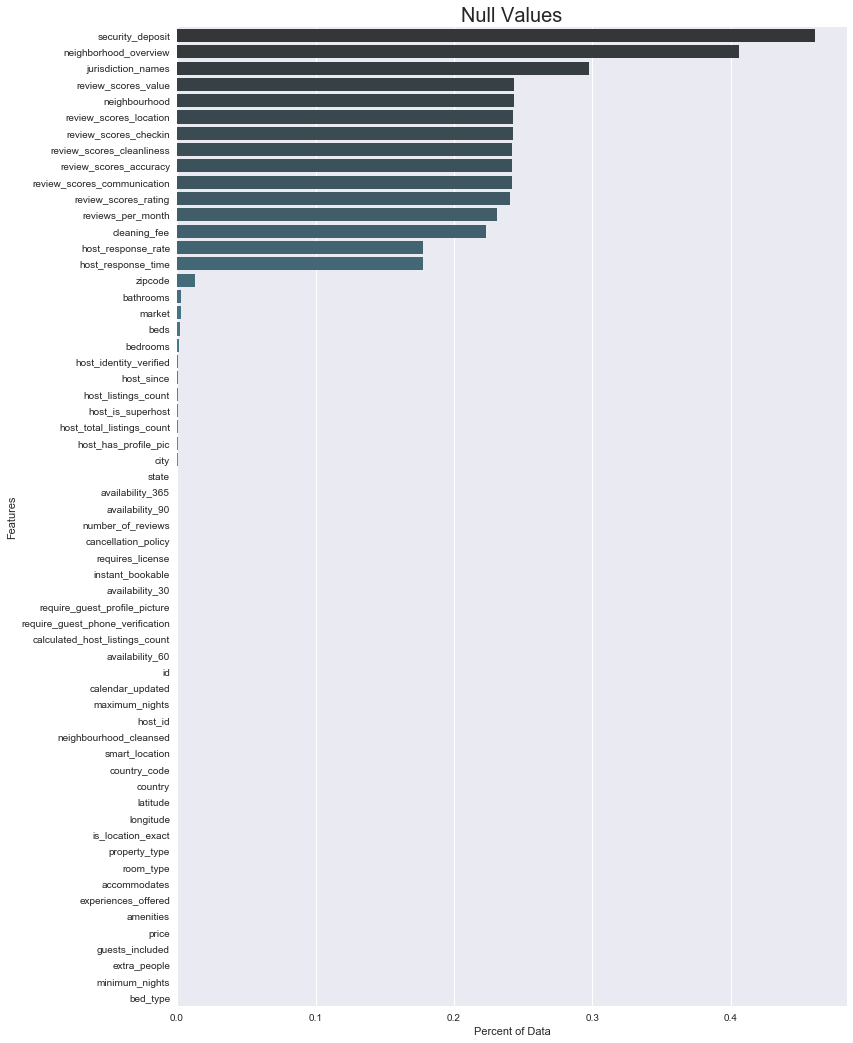

In [4]:
# Count null values
null = listing.isnull().sum(axis=0)
null = pd.DataFrame(null).reset_index()
null['percent'] = null[0]/31253 

# Plot null values, sorted
null = null.sort_values(by='percent',ascending=False)
fig, ax = plt.subplots(figsize=(12,18))
ax.set_yticklabels(null.index.values, rotation='horizontal')
sns.barplot(x=null['percent'],y=null['index'], palette='GnBu_d').set_title('Null Values',fontsize=20)
ax.set(xlabel='Percent of Data', ylabel='Features')

In [5]:
# Droping features with NaN's over 25% of instances
listing= listing.drop(['security_deposit',
                       'neighborhood_overview','jurisdiction_names','review_scores_value','review_scores_accuracy',
                       'review_scores_cleanliness','review_scores_checkin',
                       'review_scores_communication','neighbourhood','review_scores_location','experiences_offered'], axis=1)

C:\Users\peril\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


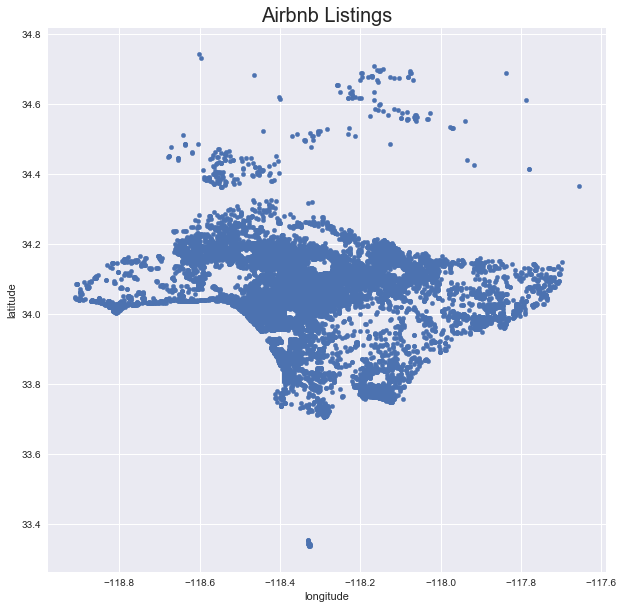

In [6]:
# Plot based on lat and long
listing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,10))
plt.legend()
plt.title('Airbnb Listings', fontsize=20)

In [7]:
# There are a lot of outliers north of Los Angeles that I won't consider as part of the area
listing = listing.query('latitude<34.35')

# There are a few outliers down towards San Diego
listing = listing.query('latitude>33.6')

## Categorical Features

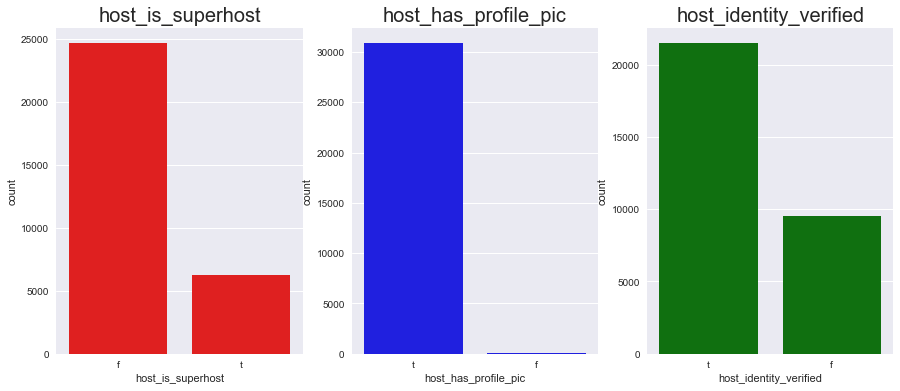

In [8]:
# Categorical plots
f, axes = plt.subplots(ncols=3, figsize=(15, 6))
sns.countplot(listing['host_is_superhost'], color="red", ax=axes[0]).set_title('host_is_superhost', fontsize=20)
sns.countplot(listing['host_has_profile_pic'], color="blue", ax=axes[1]).set_title('host_has_profile_pic', fontsize=20)
sns.countplot(listing['host_identity_verified'], color="green", ax=axes[2]).set_title('host_identity_verified', fontsize=20)

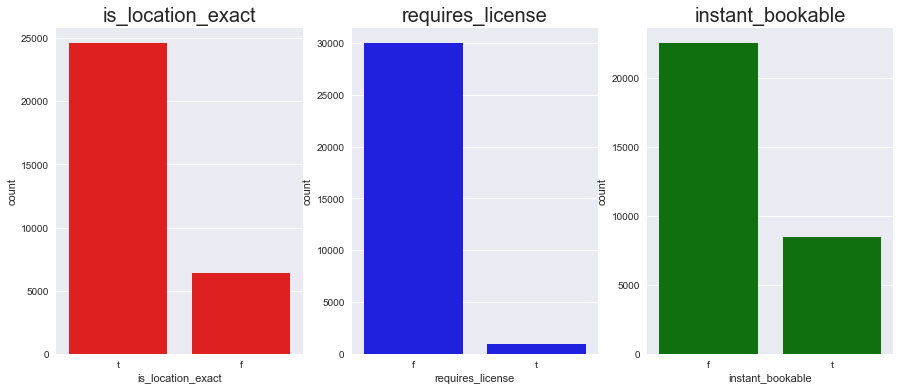

In [9]:
# Categorical plots
f, axes = plt.subplots(ncols=3, figsize=(15, 6))
sns.countplot(listing['is_location_exact'], color="red", ax=axes[0]).set_title('is_location_exact', fontsize=20)
sns.countplot(listing['requires_license'], color="blue", ax=axes[1]).set_title('requires_license', fontsize=20)
sns.countplot(listing['instant_bookable'], color="green", ax=axes[2]).set_title('instant_bookable', fontsize=20)

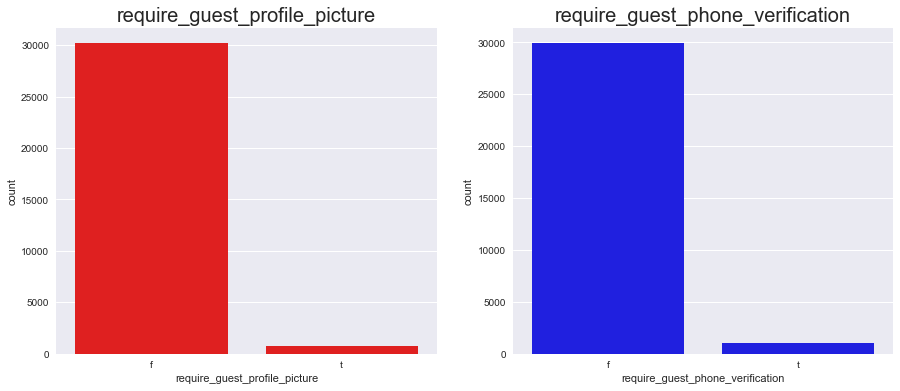

In [10]:
# Categorical plots
f, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.countplot(listing['require_guest_profile_picture'], color="red", ax=axes[0]).set_title('require_guest_profile_picture', fontsize=20)
sns.countplot(listing['require_guest_phone_verification'], color="blue", ax=axes[1]).set_title('require_guest_phone_verification', fontsize=20)

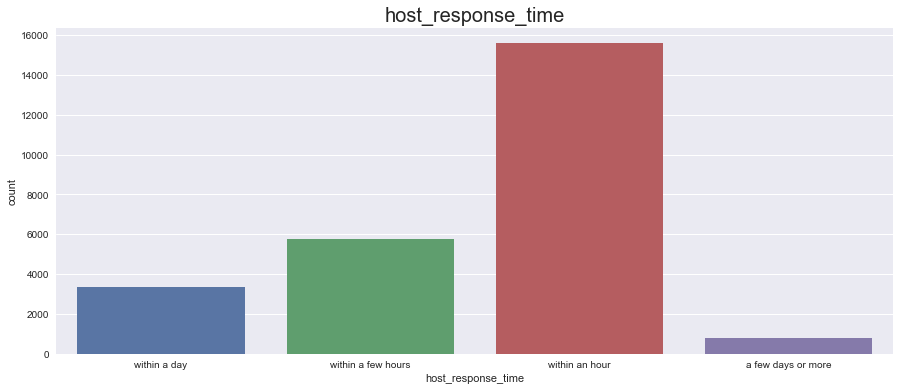

In [11]:
# Categorical plots
f, axes = plt.subplots(figsize=(15, 6))
sns.countplot(listing['host_response_time']).set_title('host_response_time', fontsize=20)

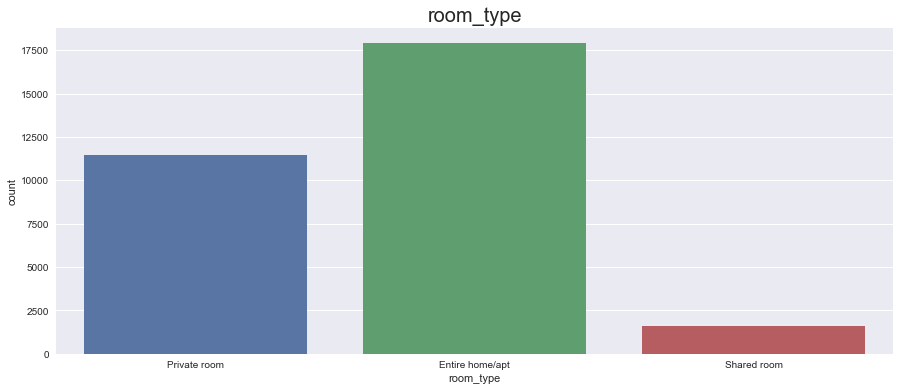

In [12]:
# Categorical plots
f, axes = plt.subplots(figsize=(15, 6))
sns.countplot(listing['room_type']).set_title('room_type', fontsize=20)

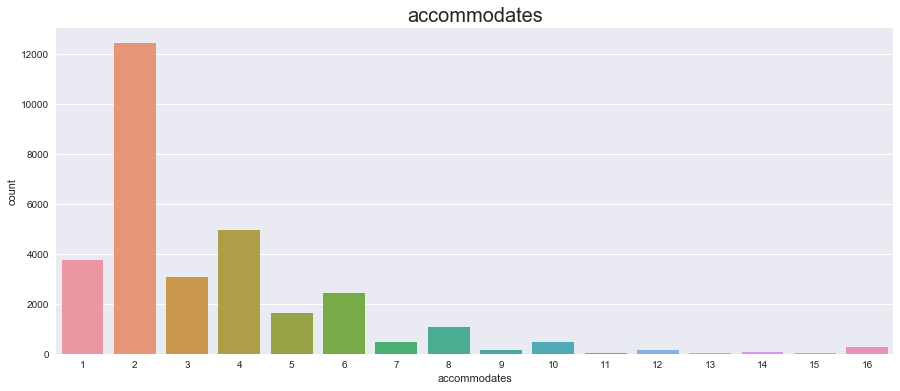

In [13]:
# Categorical plots
f, axes = plt.subplots(figsize=(15, 6))
sns.countplot(listing['accommodates']).set_title('accommodates', fontsize=20)

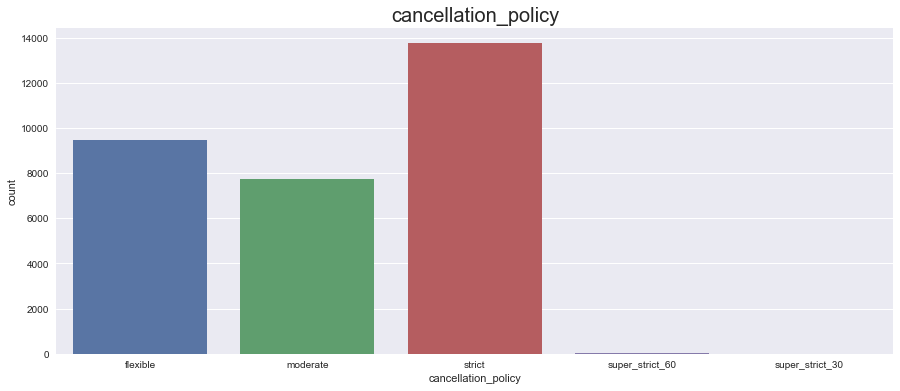

In [14]:
# Categorical plots
f, axes = plt.subplots(figsize=(15, 6))
sns.countplot(listing['cancellation_policy']).set_title('cancellation_policy', fontsize=20)

## Distributions

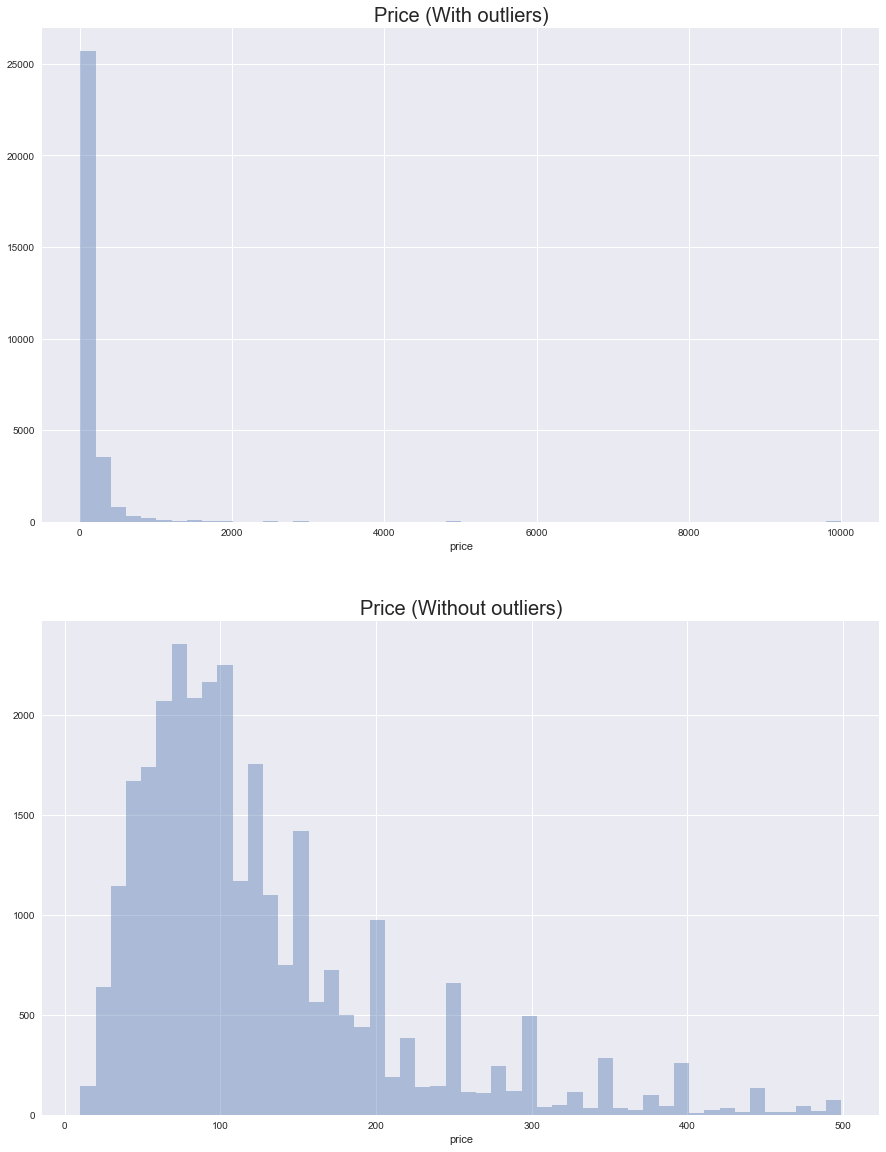

In [15]:
# Need to convert the price column to a float
listing['price'] = (listing['price'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))
listing['extra_people'] = (listing['extra_people'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

# Without outliers
pricing = listing.query('price<500')

# Review distribution
f, axes = plt.subplots(nrows=2, figsize=(15, 20))
sns.distplot(listing['price'], kde=False, ax=axes[0]).set_title('Price (With outliers)', fontsize=20)
sns.distplot(pricing['price'], kde=False, ax=axes[1]).set_title('Price (Without outliers)', fontsize=20)

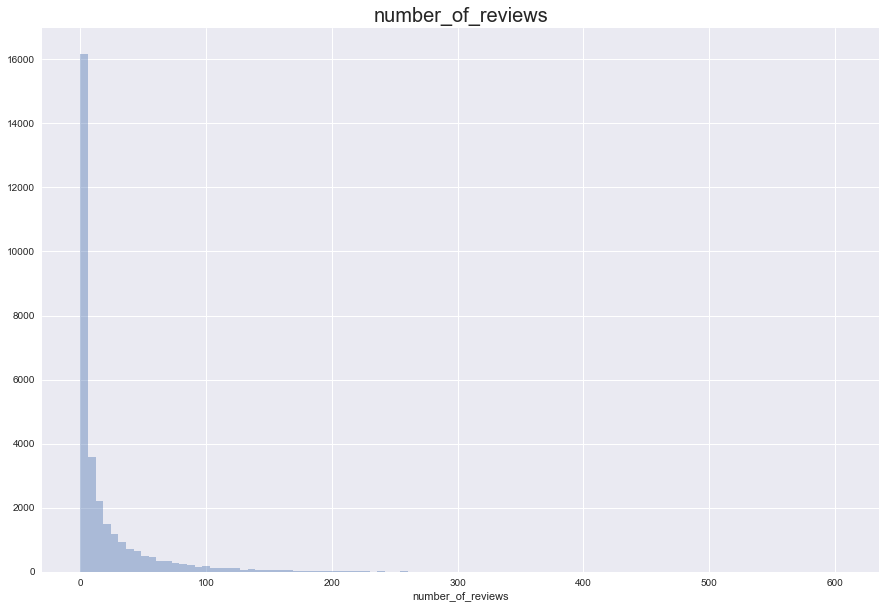

In [16]:
# Review distribution
f, axes = plt.subplots(figsize=(15, 10))
sns.distplot(listing['number_of_reviews'], bins=100, kde=False).set_title('number_of_reviews', fontsize=20)

## Final Cleaning

In [17]:
# Droping features with little to no variation
listing= listing.drop(['host_has_profile_pic','requires_license',
                       'require_guest_profile_picture','neighbourhood_cleansed',
                       'require_guest_phone_verification'], axis=1)

# Drop lat and long since we don't need it anymore
listing= listing.drop(['latitude','longitude'],axis=1)

In [18]:
# See how we did
listing.shape

(30998, 42)

In [19]:
listing.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month
4,7898757,41646908,2015-08-16,NaN,NaN,f,1.0,1.0,t,Los Angeles,CA,90007,Los Angeles,"Los Angeles, CA",US,United States,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Free pa...",30.0,$5.00,1,10.0,1,90,15 months ago,0,0,0,0,3,93.0,f,flexible,1,0.18
5,11254337,54243025,2016-01-11,within a day,100%,f,1.0,1.0,f,Los Angeles,CA,90007,Los Angeles,"Los Angeles, CA",US,United States,t,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",35.0,NaN,1,15.0,2,1125,3 weeks ago,4,17,32,32,0,NaN,f,flexible,1,NaN
6,16068508,89420054,2016-08-11,within a few hours,96%,t,2.0,2.0,t,Los Angeles,CA,90007,Los Angeles,"Los Angeles, CA",US,United States,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Free parking on...",45.0,$5.00,1,10.0,1,1125,a week ago,6,21,42,42,38,98.0,f,moderate,2,7.92
7,654641,2324191,2012-05-08,within a few hours,96%,f,23.0,23.0,t,Los Angeles,CA,90007,Los Angeles,"Los Angeles, CA",US,United States,t,House,Private room,2,NaN,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,Washe...",56.0,$20.00,1,20.0,1,1125,today,22,52,82,357,23,89.0,f,strict,19,0.41
8,14859779,93062529,2016-09-01,NaN,NaN,f,1.0,1.0,t,Los Angeles,CA,90007,Los Angeles,"Los Angeles, CA",US,United States,t,House,Entire home/apt,2,1.5,2.0,1.0,Real Bed,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",350.0,NaN,1,0.0,1,1125,8 months ago,29,59,89,364,0,NaN,f,flexible,1,NaN


In [20]:
# Summary statistics
listing.describe()

,id,host_id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month
count,3.099800e+04,3.099800e+04,30984.000000,30984.000000,30998.000000,30902.000000,30963.000000,30940.00000,30998.000000,30998.000000,30998.000000,30998.000000,3.099800e+04,30998.000000,30998.000000,30998.000000,30998.000000,30998.000000,23556.000000,30998.000000,23857.000000
mean,1.084765e+07,3.618444e+07,5.200426,5.200426,3.425963,1.380655,1.349223,1.88914,180.402607,1.718208,13.403994,3.217950,2.085936e+05,14.124589,31.280050,49.930415,199.155558,20.923834,94.206402,3.562972,1.858952
std,5.529498e+06,3.450288e+07,24.240628,24.240628,2.478397,0.827553,0.990636,1.52372,419.647718,1.499637,23.492855,8.193343,2.112562e+07,11.730044,22.763164,33.721132,138.586602,38.220812,8.033565,5.570428,2.026734
min,1.090000e+02,5.900000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,10.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,0.020000
25%,6.241242e+06,7.388992e+06,1.000000,1.000000,2.000000,1.000000,1.000000,1.00000,69.000000,1.000000,0.000000,1.000000,3.000000e+01,1.000000,8.000000,17.000000,68.000000,1.000000,92.000000,1.000000,0.410000
50%,1.215220e+07,2.463256e+07,2.000000,2.000000,2.000000,1.000000,1.000000,1.00000,100.000000,1.000000,0.000000,2.000000,1.125000e+03,13.000000,32.000000,56.000000,207.000000,6.000000,96.000000,1.000000,1.120000
75%,1.570299e+07,5.573500e+07,4.000000,4.000000,4.000000,1.500000,2.000000,2.00000,170.000000,2.000000,20.000000,3.000000,1.125000e+03,27.000000,55.000000,84.000000,341.000000,23.000000,100.000000,3.000000,2.740000
max,1.852404e+07,1.285513e+08,855.000000,855.000000,16.000000,8.000000,10.000000,16.00000,10000.000000,16.000000,300.000000,365.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,605.000000,100.000000,49.000000,90.000000


## Feature Engineering